In [2]:
import os
import re
import collections

import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

from nltk import tokenize
from bs4 import BeautifulSoup
from wordcloud import WordCloud
from mpl_toolkits.mplot3d import Axes3D

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

In [7]:
base_path = "data"

train_file = os.path.join(base_path, "train.csv")
test_file = os.path.join(base_path, "test.csv")

In [8]:
train_df = pd.read_csv(train_file)
test_df = pd.read_csv(test_file)

train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


## Data exploration

### Target

In [9]:
target_names = ["Not real disaster", "Real disaster"]
real_disaster = 1

color = ["g", "r"]

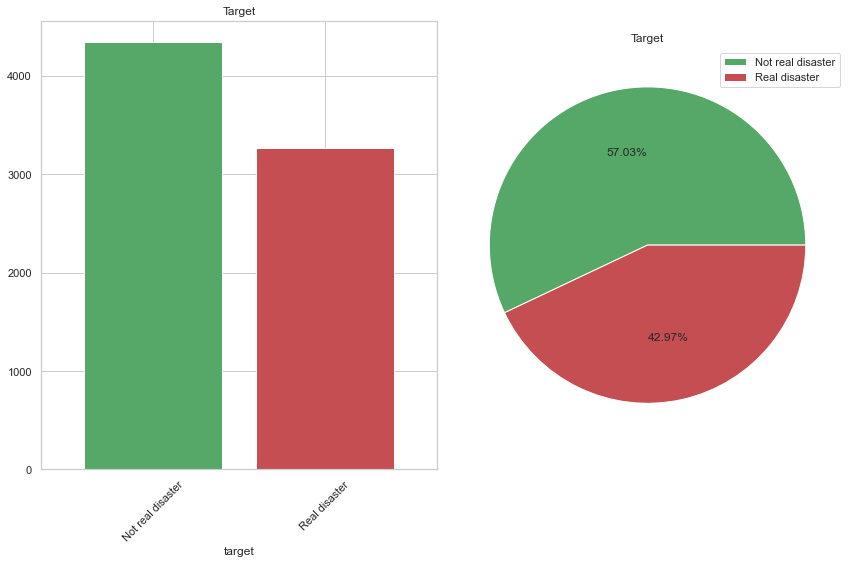

In [10]:
fig = plt.figure(figsize=(12, 8))

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

train_df.groupby("target").size().sort_values(ascending=False).plot(
    kind="bar", width=0.8, title="Target", ax=ax1, rot=45, legend=False, color=color)
ax1.set_xticklabels(target_names)

train_df.groupby("target").size().sort_values(ascending=False).plot(
    kind="pie", title="Target", ax=ax2, autopct="%.2f%%", labels=None, colors=color)
ax2.legend(target_names)
ax2.axis("off")

fig.tight_layout()

### Keyword

In [7]:
# Convert column to string
train_df.loc[:, "keyword"] = train_df.keyword.astype("string")
train_df.loc[:, "keyword"] = train_df.keyword.fillna("")

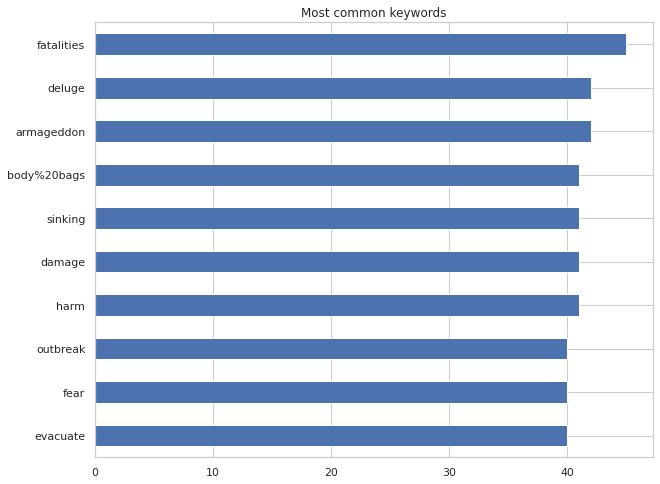

In [8]:
def generate_words_count(words, reversed_sorted=True):
    words_counter = collections.Counter(words)
    common_words_df = pd.DataFrame(words_counter, index=[0]).transpose()
    common_words_df.columns = ["counts"]
    
    if reversed_sorted:
        asc = True
    else:
        asc = False
    return common_words_df.sort_values(by="counts", ascending=asc)

keywords = list(filter(None, train_df.keyword.values))
keywords_df = generate_words_count(keywords)

keywords_df.tail(10).plot(kind="barh", figsize=(10, 8), legend=False, title="Most common keywords")

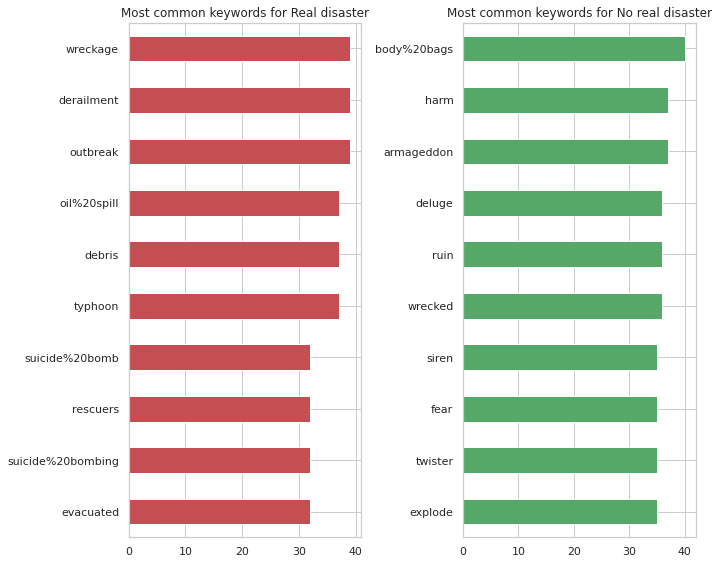

In [136]:
cond_real = train_df.target == real_disaster
real_disaster_keywords = list(filter(None, train_df[cond_real].keyword.values))
no_disaster_keywords = list(filter(None, train_df[~cond_real].keyword.values))

keywords_real_df = generate_words_count(real_disaster_keywords)
keywords_no_df = generate_words_count(no_disaster_keywords)

fig = plt.figure(figsize=(15, 8))

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

keywords_real_df.tail(10).plot(kind="barh", figsize=(10, 8), legend=False, title="Most common keywords for Real disaster", ax=ax1, color="r")
keywords_no_df.tail(10).plot(kind="barh", figsize=(10, 8), legend=False, title="Most common keywords for No real disaster", ax=ax2, color="g")

fig.tight_layout()

In [28]:
train_df.loc[:, "with_keyword"] = train_df.keyword.str.len().astype(bool)
train_df.loc[:, "keyword_len"] = train_df.keyword.str.len()

[Text(0, 0, 'No real disaster'), Text(0, 0, 'Real disaster')]

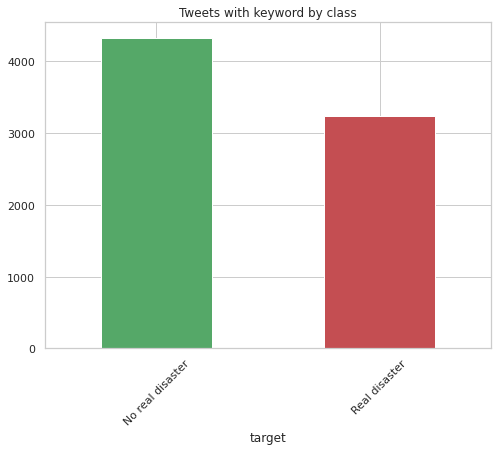

In [25]:
fig, ax = plt.subplots(figsize=(8, 6))

train_df.groupby("target")["with_keyword"].sum().plot(kind="bar", ax=ax, rot=45, title="Tweets with keyword by class", color=color)

ax.set_xticklabels(target_names)

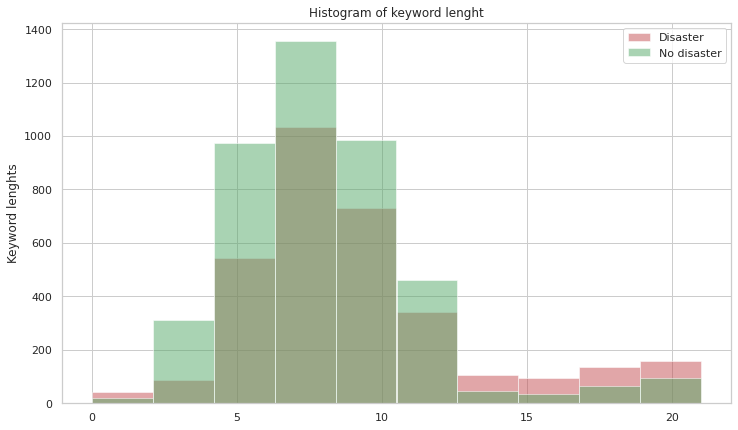

In [30]:
real_keyword_len = train_df[cond_real].keyword_len
no_keyword_len = train_df[~cond_real].keyword_len

fig, ax = plt.subplots(figsize=(12, 7))

kwargs = dict(alpha=0.5, bins=10)
plt.hist(real_keyword_len, **kwargs, color='r', label='Disaster')
plt.hist(no_keyword_len, **kwargs, color='g', label='No disaster')

plt.gca().set(title='Histogram of keyword lenght', ylabel='Keyword lenghts')
plt.legend()

### Location

In [44]:
train_df.loc[:, "location"] = train_df.location.astype("string")
train_df.loc[:, "location"] = train_df.location.fillna("")

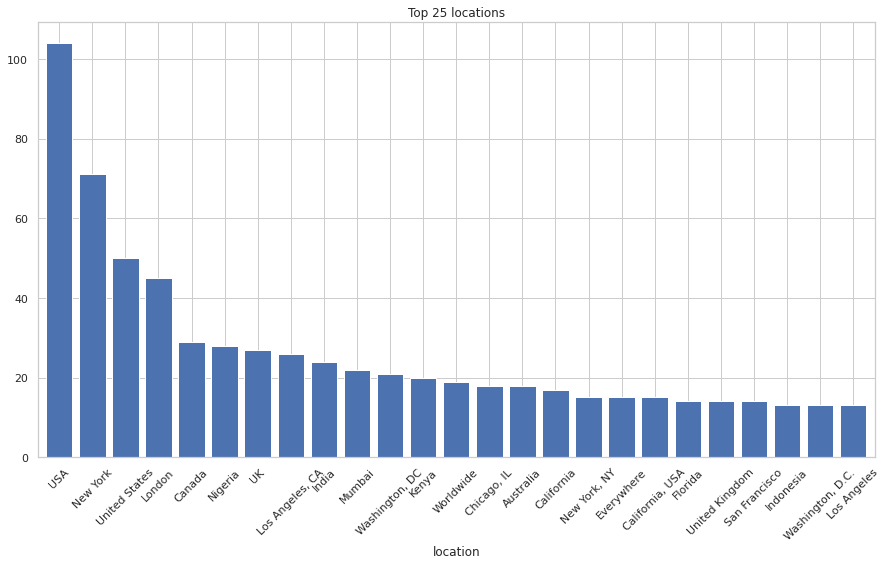

In [33]:
train_df.groupby("location").size().sort_values(ascending=False)[:25].plot(
    kind="bar", figsize=(15, 8), width=0.8, title="Top 25 locations", rot=45)

In [46]:
train_df.loc[:, "with_location"] = train_df.location.str.len().astype(bool)

[Text(0, 0, 'No real disaster'), Text(0, 0, 'Real disaster')]

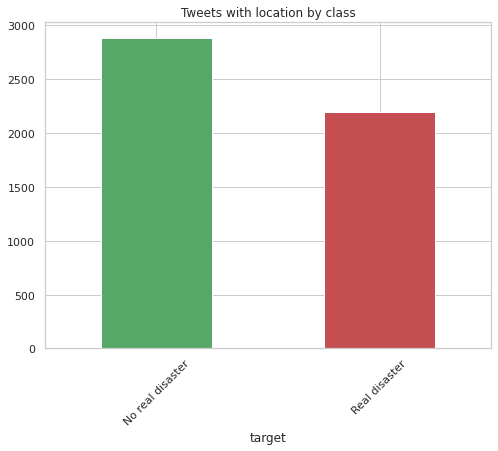

In [48]:
fig, ax = plt.subplots(figsize=(8, 6))

train_df.groupby("target")["with_location"].sum().plot(kind="bar", ax=ax, rot=45, title="Tweets with location by class", color=color)

ax.set_xticklabels(target_names)

Create a 3D plot with features "with_location", "with_keyword" and "keyword_len"

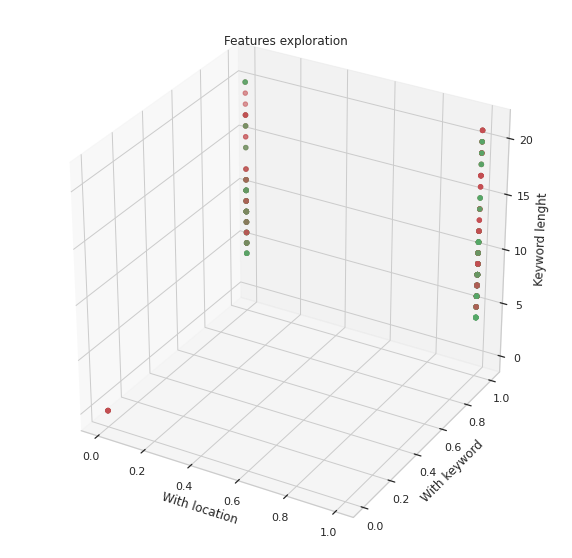

In [85]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

sample_train_df = train_df.sample(n=500)

x = sample_train_df.with_location.astype(int).values
y = sample_train_df.with_keyword.astype(int).values
z = sample_train_df.keyword_len.astype(int).values

label_colors = ["g" if t == 0 else "r" for t in sample_train_df.target.values]

ax.scatter(x, y, z, c=label_colors, marker='o')

ax.set_title("Features exploration")
ax.set_xlabel('With location')
ax.set_ylabel('With keyword')
ax.set_zlabel('Keyword lenght')

plt.show()

### Text

Choose randomly 5 tweets for visualize text content

In [89]:
train_df.loc[:, "text"] = train_df.text.astype("string")

In [98]:
for tweet, keyword, label in train_df[["text", "keyword", "target"]].sample(n=5).values:
    print(f"{keyword}\n{tweet}\n{target_names[label]}\n")

apocalypse
@HoneyBunzGem @primalkitchen I feel like me doing a pull-up is one of the stages of the Apocalypse.
Not real disaster

arsonist
Arsonists being blamed for a blaze at a plastics recycling business in Adelaide | @pcaldicott7 reports. #7NewsAdl http://t.co/r1Xwdnvb0g
Not real disaster

collide
You either ride with us or collide with us. It's as simple as that for me and my niggas.
Not real disaster

debris
MH370: Reunion debris is from missing Malaysia flight http://t.co/6iMe8KJaCV
Real disaster

avalanche
2 TIX 10/3 Frozen Fury XVII: Los Angeles Kings v Avalanche 103 Row:AA MGM Grand http://t.co/kBtZZZG2Tp
Not real disaster



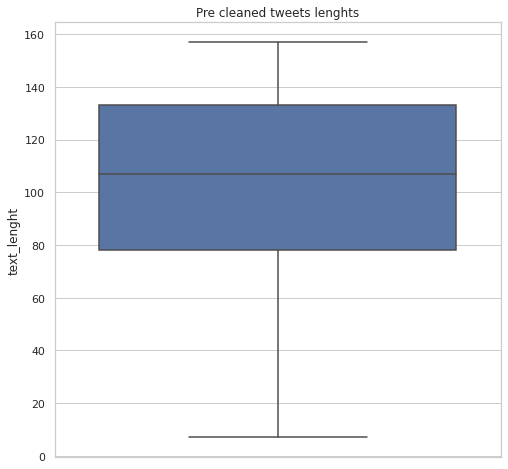

In [92]:
train_df.loc[:, "text_lenght"] = train_df.text.str.len()

fig, ax = plt.subplots(figsize=(8, 8))

sns.boxplot(data=train_df, y="text_lenght", ax=ax)
_ = ax.set_title("Pre cleaned tweets lenghts")

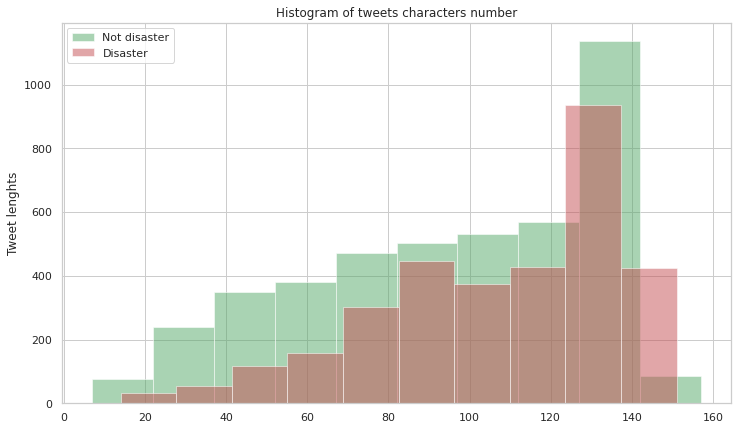

In [102]:
no_disaster_hist = train_df[~cond_real].text_lenght
disaster_hist = train_df[cond_real].text_lenght

fig, ax = plt.subplots(figsize=(12, 7))

kwargs = dict(alpha=0.5, bins=10)
plt.hist(no_disaster_hist, **kwargs, color='g', label='Not disaster')
plt.hist(disaster_hist, **kwargs, color='r', label='Disaster')

plt.gca().set(title='Histogram of tweets characters number', ylabel='Tweet lenghts')
plt.legend()

In [114]:
train_df.loc[:, "splited_text"] = train_df.text.str.split(" ")
train_df.loc[:, "text_words_number"] = train_df.splited_text.apply(lambda x: len(x))

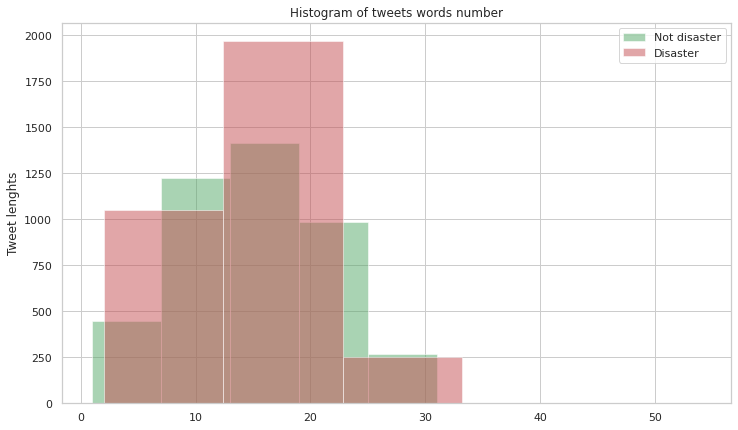

In [115]:
no_disaster_hist = train_df[~cond_real].text_words_number
disaster_hist = train_df[cond_real].text_words_number

fig, ax = plt.subplots(figsize=(12, 7))

kwargs = dict(alpha=0.5, bins=5)
plt.hist(no_disaster_hist, **kwargs, color='g', label='Not disaster')
plt.hist(disaster_hist, **kwargs, color='r', label='Disaster')

plt.gca().set(title='Histogram of tweets words number', ylabel='Tweet lenghts')
plt.legend()

In [121]:
def generate_word_cloud(corpus, title):
    frequences_dict = pd.Series(corpus).value_counts().to_dict()
    wordcloud = WordCloud().generate_from_frequencies(frequences_dict)

    fig = plt.subplots(figsize=(20, 12))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title, fontsize=32)
    plt.show()

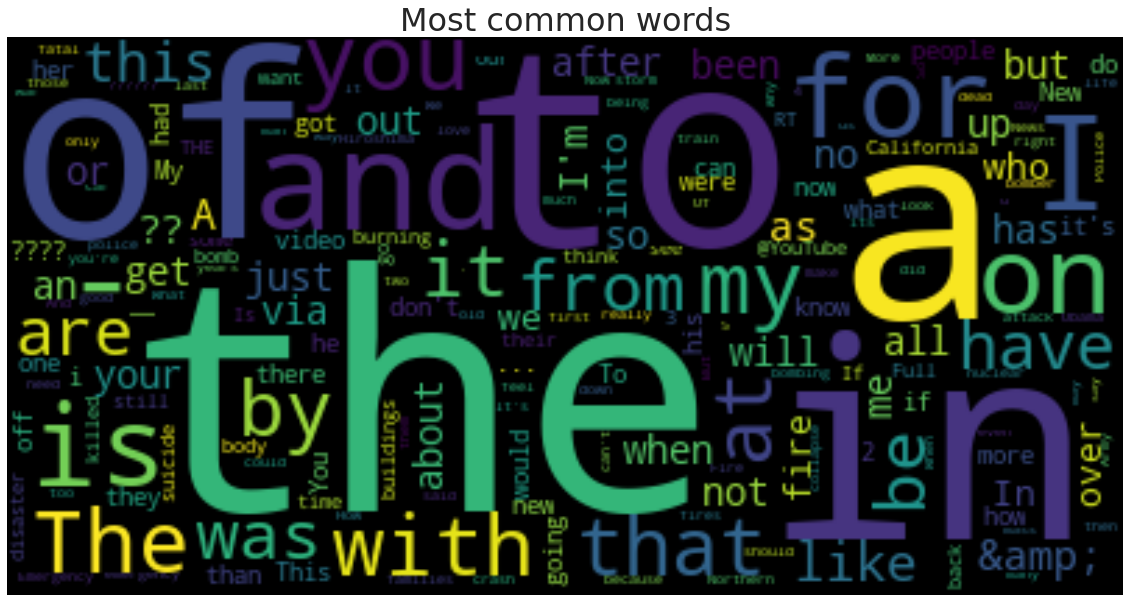

In [123]:
text_corpus = [word for tweet in train_df.splited_text.values for word in tweet]
generate_word_cloud(text_corpus, "Most common words")

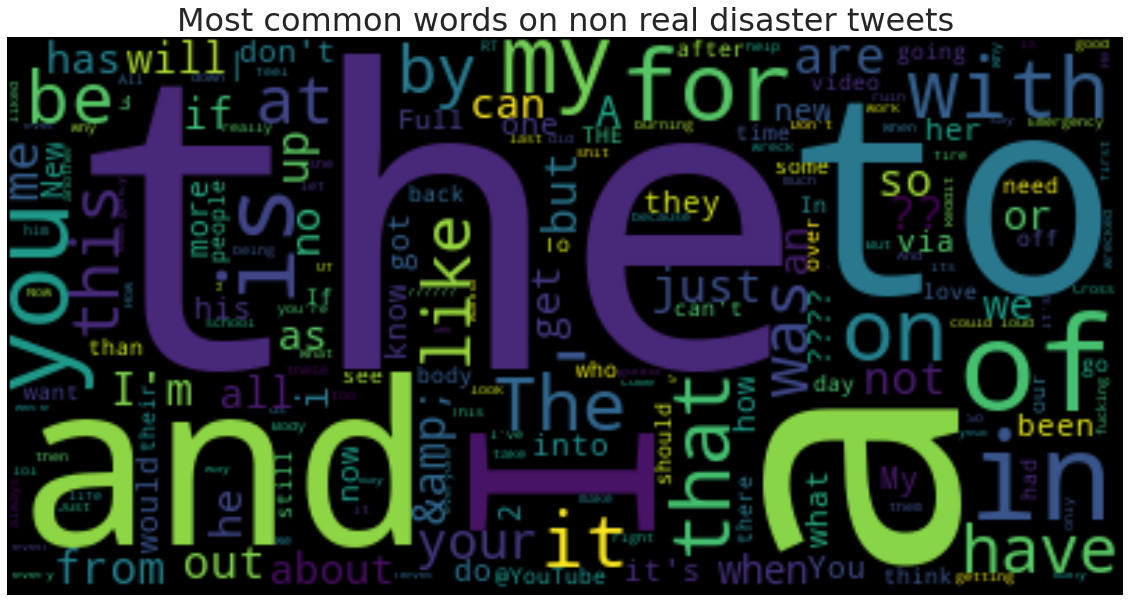

In [124]:
text_corpus = [word for tweet in train_df[~cond_real].splited_text.values for word in tweet]
generate_word_cloud(text_corpus, "Most common words on non real disaster tweets")

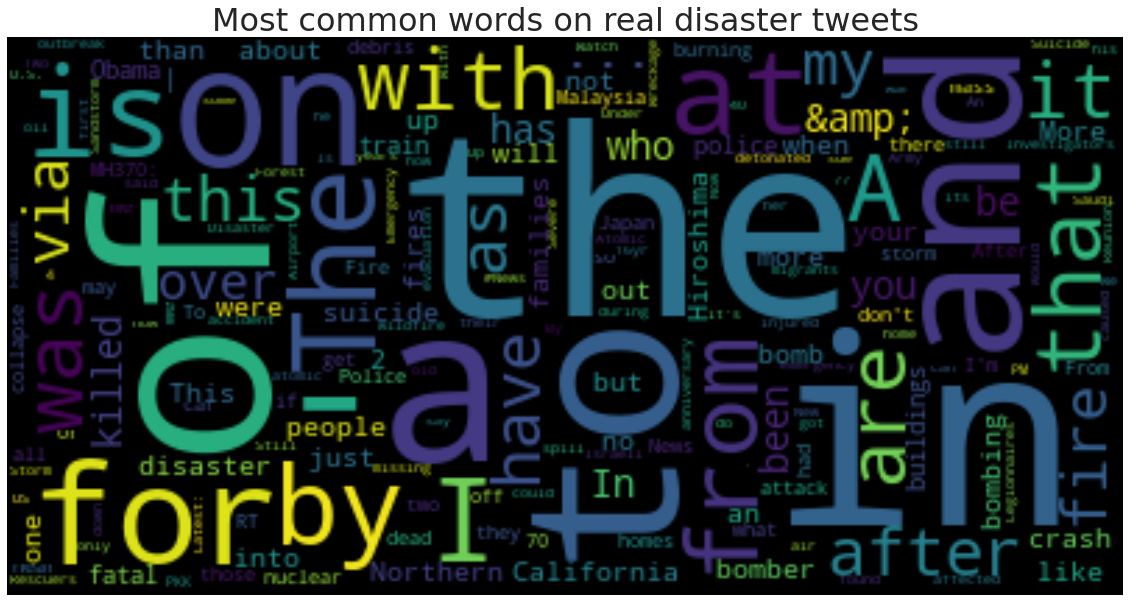

In [125]:
text_corpus = [word for tweet in train_df[cond_real].splited_text.values for word in tweet]
generate_word_cloud(text_corpus, "Most common words on real disaster tweets")

In [128]:
def get_top_text_n_grams(text, n_grams=(2, 2), n=None):
    vec = CountVectorizer(ngram_range=n_grams).fit(text)
    bag_of_words = vec.transform(text)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key=lambda x: x[1], reverse=True)
    
    return words_freq[:n]

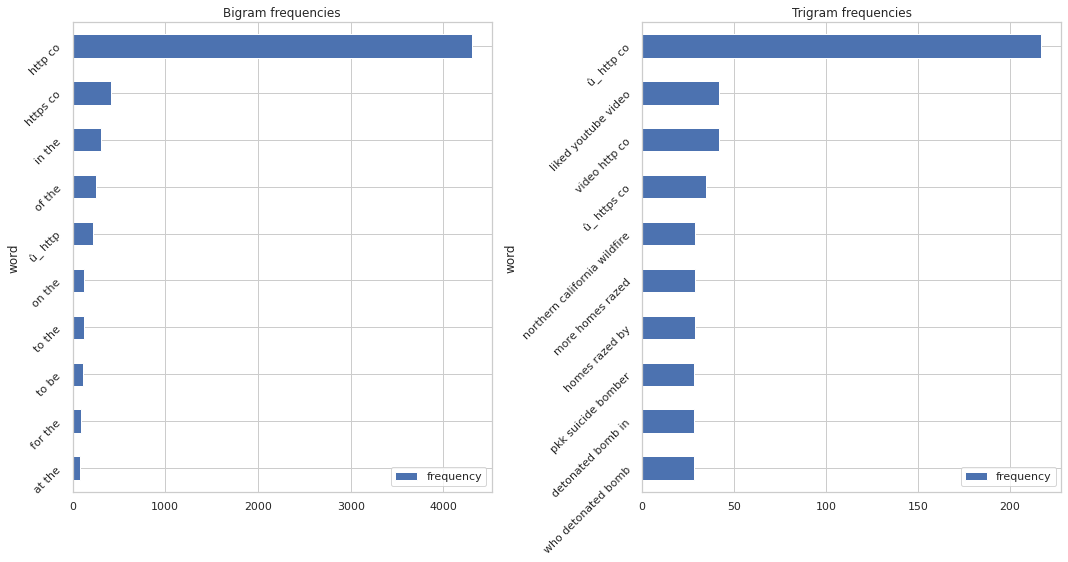

In [137]:
bigrame_df = pd.DataFrame(get_top_text_n_grams(train_df.text), columns=["word", "frequency"])
trigrame_df = pd.DataFrame(get_top_text_n_grams(train_df.text, n_grams=(3, 3)), columns=["word", "frequency"])

fig = plt.figure(figsize=(15, 8))

ax1 = fig.add_subplot(121)
bigrame_df.sort_values(by="frequency").tail(10).plot(kind="barh", x="word", y="frequency", rot=45, ax=ax1, title="Bigram frequencies")

ax2 = fig.add_subplot(122)
trigrame_df.sort_values(by="frequency").tail(10).plot(kind="barh", x="word", y="frequency", rot=45, ax=ax2, title="Trigram frequencies")

fig.tight_layout()

### Text cleaning

In [180]:
def clean_html_encoding(text):
    text = BeautifulSoup(text, 'lxml').get_text()
    return text

def remove_html_tags(text):
    html = re.compile(r'<.*?>')
    return html.sub(r'',text)

def remove_urls(text):
    links_reg = re.compile(r'https?://[A-Za-z0-9./]+')
    return links_reg.sub(r'', text)

def remove_mentions(text):
    mentions_reg = re.compile(r'@[A-Za-z0-9]+')
    return mentions_reg.sub(r'', text)

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_puntuation(tokens):
    return [token for token in tokens if token.isalpha()]

def lower_text(text):
    return text.lower()

def clean_text(text, return_list=True):
    text = clean_html_encoding(text)
    text = remove_html_tags(text)
    text = remove_urls(text)
    text = remove_mentions(text)
    text = remove_emoji(text)
    
    text = lower_text(text)
    tokens = tokenize.word_tokenize(text)
    tokens = remove_puntuation(tokens)
    
    return " ".join(tokens)

In [188]:
train_df.loc[:, "cleaned_text"] = train_df.text.apply(clean_text)
train_df.loc[:, "cleaned_text_lenght"] = train_df.cleaned_text.str.len()

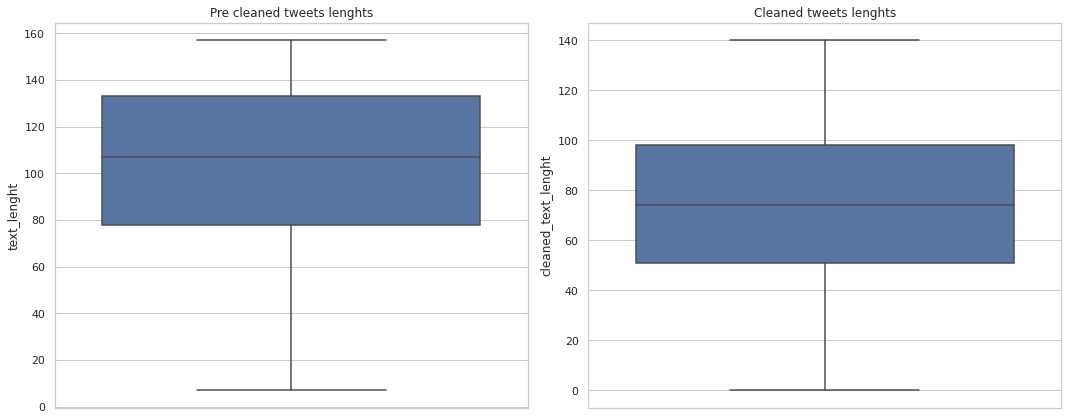

In [192]:
fig = plt.figure(figsize=(15, 6))

ax1 = fig.add_subplot(121)
sns.boxplot(data=train_df, y="text_lenght", ax=ax1)
ax1.set_title("Pre cleaned tweets lenghts")

ax2 = fig.add_subplot(122)
sns.boxplot(data=train_df, y="cleaned_text_lenght", ax=ax2)
ax2.set_title("Cleaned tweets lenghts")

fig.tight_layout()

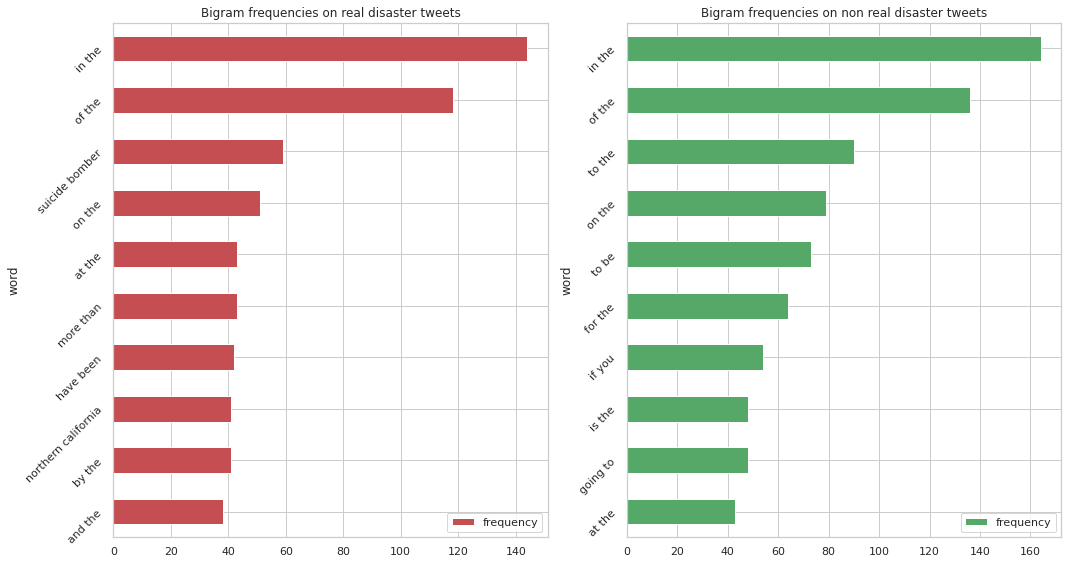

In [200]:
real_bigrame_df = pd.DataFrame(get_top_text_n_grams(train_df[cond_real].cleaned_text), columns=["word", "frequency"])
no_brigam_df = pd.DataFrame(get_top_text_n_grams(train_df[~cond_real].cleaned_text), columns=["word", "frequency"])

fig = plt.figure(figsize=(15, 8))

ax1 = fig.add_subplot(121)
real_bigrame_df.sort_values(by="frequency").tail(10).plot(kind="barh", x="word", y="frequency", rot=45, ax=ax1, 
                                                          title="Bigram frequencies on real disaster tweets", color="r")

ax2 = fig.add_subplot(122)
no_brigam_df.sort_values(by="frequency").tail(10).plot(kind="barh", x="word", y="frequency", rot=45, ax=ax2, 
                                                       title="Bigram frequencies on non real disaster tweets", color="g")

fig.tight_layout()

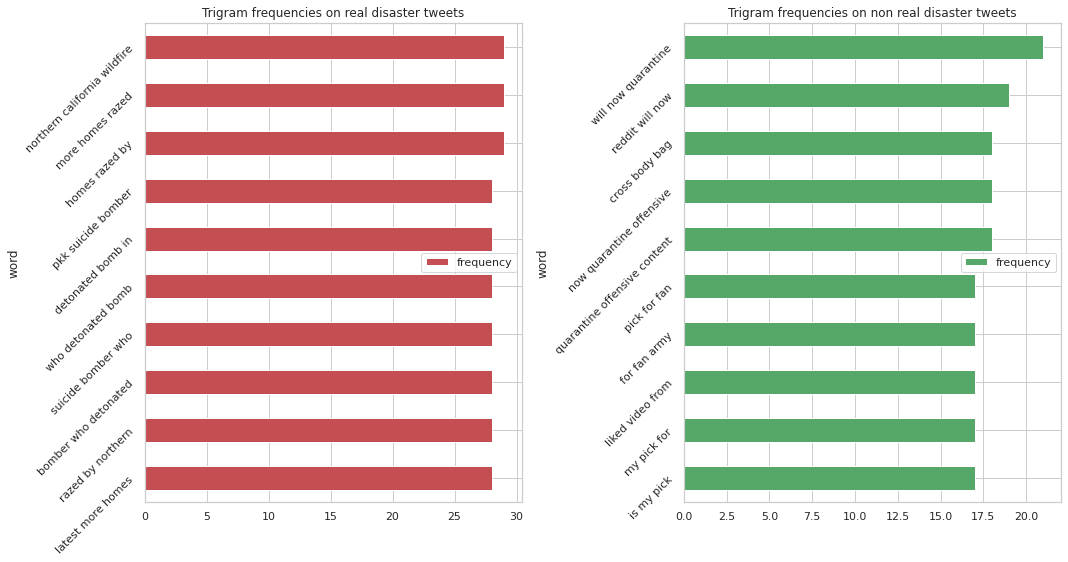

In [201]:
real_trigrame_df = pd.DataFrame(get_top_text_n_grams(train_df[cond_real].cleaned_text, n_grams=(3, 3)), columns=["word", "frequency"])
no_trigam_df = pd.DataFrame(get_top_text_n_grams(train_df[~cond_real].cleaned_text, n_grams=(3, 3)), columns=["word", "frequency"])

fig = plt.figure(figsize=(15, 8))

ax1 = fig.add_subplot(121)
real_trigrame_df.sort_values(by="frequency").tail(10).plot(kind="barh", x="word", y="frequency", rot=45, ax=ax1, 
                                                          title="Trigram frequencies on real disaster tweets", color="r")

ax2 = fig.add_subplot(122)
no_trigam_df.sort_values(by="frequency").tail(10).plot(kind="barh", x="word", y="frequency", rot=45, ax=ax2, 
                                                       title="Trigram frequencies on non real disaster tweets", color="g")

fig.tight_layout()